In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

Question 1

Image Reconstruction - Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates
(
X
,
Y
)
 to the pixel colors
(
R
,
G
,
B
)
. Here,
(
X
,
Y
)
 represents the coordinates of the pixels, and
(
R
,
G
,
B
)
 represents the color values at those coordinates. Display both the original image and the reconstructed image. Also, calculate and report the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images. [1.5 Mark]

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore') #ignore the warnings and focus on important features

# Set env CUDA_LAUNCH_BLOCKING=1,  it ensures that the operations complete before proceeding to the next steps.
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange #useful for rearranging, reshaping, and transposing
    print("Already installed, successfully imported rearrange")
except ImportError:
    %pip install einops
    from einops import rearrange
image_path = r"/content/cat.png"
img = torchvision.io.read_image(image_path)
img.shape

Already installed, successfully imported rearrange


torch.Size([4, 456, 499])

In [ ]:
img = img[:3, :, :]  #removing a extra alpha channel
img.shape

torch.Size([3, 456, 499])

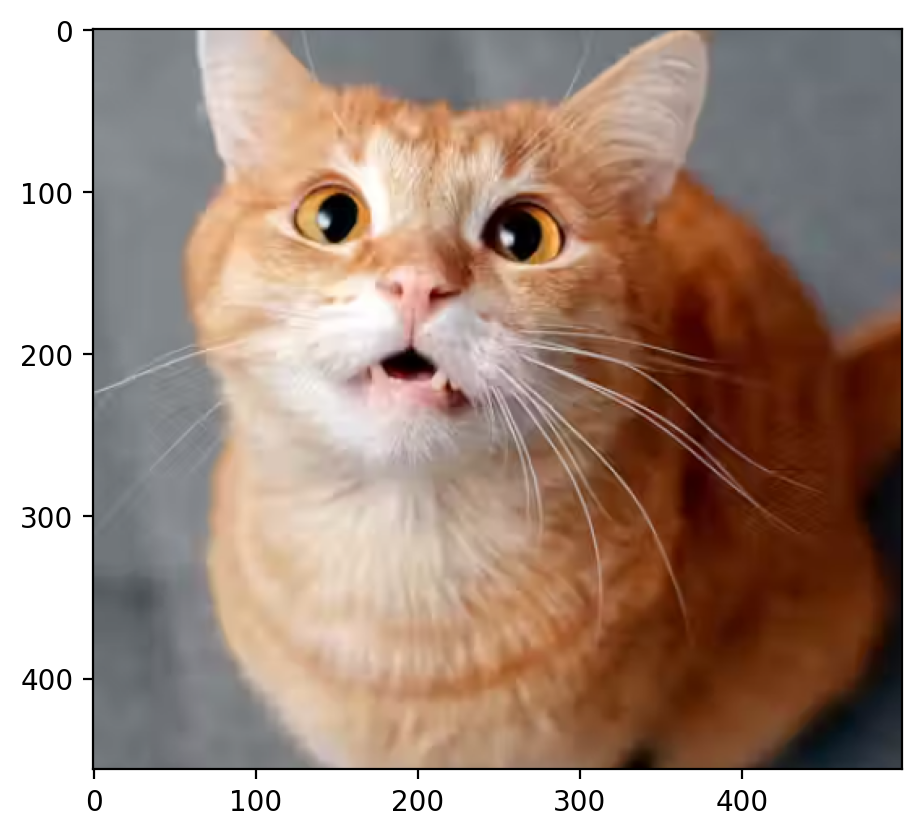

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [ ]:

from sklearn import preprocessing


scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))

# cales features to a specified range
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled.shape

torch.Size([3, 456, 499])

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(),20 ,60, 300, 300)
crop.shape

torch.Size([3, 300, 300])

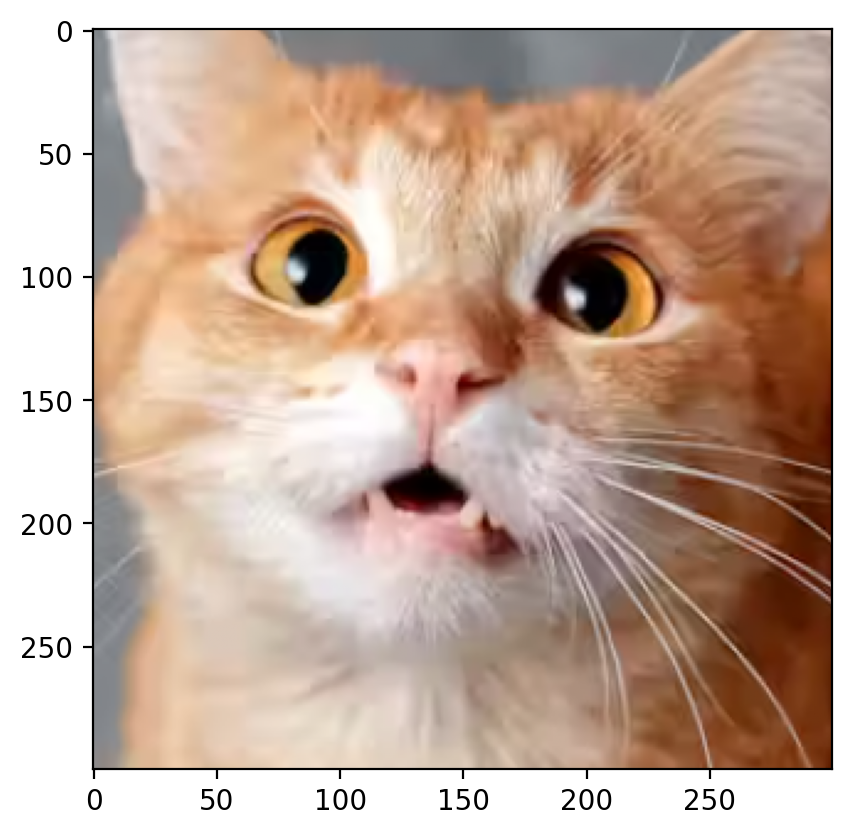

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [ ]:
def create_coordinate_map(img):

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
cat_X, cat_Y = create_coordinate_map(crop)
cat_X.shape, cat_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [ ]:

# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(cat_X.cpu())

# Scale the X coordinates
cat_X_scaled = scaler_X.transform(cat_X.cpu())

# Move the scaled X coordinates to the GPU
cat_X_scaled = torch.tensor(cat_X_scaled).to(device)

# Set to dtype float32
cat_X_scaled = cat_X_scaled.float()
cat_X_scaled

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9933],
        [-1.0000, -0.9866],
        ...,
        [ 1.0000,  0.9866],
        [ 1.0000,  0.9933],
        [ 1.0000,  1.0000]])

In [ ]:
# defines and initializes a simple linear model using PyTorch
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
      #number of input and output features
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
net = LinearModel(2, 3)
net.to(device)

net

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss() #Initializes the loss function to Mean Squared Error
    # Initializes the Adam optimizer with the specified learning rate and parameters from the model.
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()  # Zero the gradients
        outputs = net(X)  # Forward pass

        loss = criterion(outputs, Y)  # Compute loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update model parameters

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")#print the loss after each 100 epoch
    return loss.item()

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
# create RFF features

def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    # n_components desides the number of fourier features
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:
X_rff = create_rff_features(cat_X_scaled, 3750, 0.008)
X_rff.shape

torch.Size([90000, 3750])

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, cat_Y, 2500)

Epoch 0 loss: 0.421991
Epoch 100 loss: 0.082488
Epoch 200 loss: 0.037158
Epoch 300 loss: 0.033036
Epoch 400 loss: 0.032166
Epoch 500 loss: 0.031760
Epoch 600 loss: 0.031532
Epoch 700 loss: 0.031389
Epoch 800 loss: 0.031290
Epoch 900 loss: 0.031215
Epoch 1000 loss: 0.031156
Epoch 1100 loss: 0.031105
Epoch 1200 loss: 0.031060
Epoch 1300 loss: 0.031018
Epoch 1400 loss: 0.030978
Epoch 1500 loss: 0.030940
Epoch 1600 loss: 0.030903
Epoch 1700 loss: 0.030867
Epoch 1800 loss: 0.030831
Epoch 1900 loss: 0.030797
Epoch 2000 loss: 0.030763
Epoch 2100 loss: 0.030731
Epoch 2200 loss: 0.030699
Epoch 2300 loss: 0.030668
Epoch 2400 loss: 0.030639


0.030610648915171623

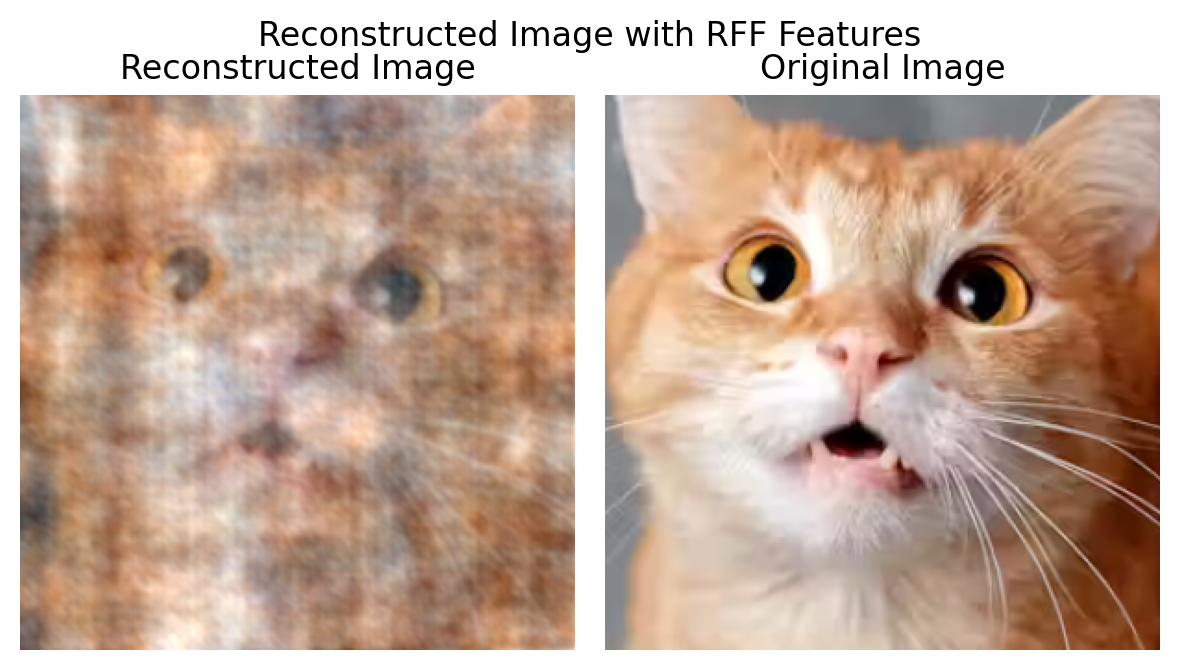

In [ ]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [ ]:
crop.max(), crop.min()

(tensor(1., dtype=torch.float64), tensor(0., dtype=torch.float64))

In [ ]:
def calculate_rmse(original_img, reconstructed_img):
    # Convert images to numpy arrays for RMSE calculation

    original_img = original_img.cpu().numpy()
    reconstructed_img = reconstructed_img.cpu().numpy()

    # Calculate RMSE
    mse = np.mean((original_img - reconstructed_img) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_psnr(original_img, reconstructed_img):

    original_img = original_img.cpu().numpy()
    reconstructed_img = reconstructed_img.cpu().numpy()

    # Calculate MSE
    mse = np.mean((original_img - reconstructed_img) ** 2)

    # Calculate PSNR
    if mse == 0:
        return float('inf')  # PSNR is infinite if MSE is zero
    max_pixel = 1.0  #images are normalized to [0, 1]
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Generate reconstructed image
net.eval()
with torch.no_grad():
    outputs = net(X_rff)

# Reshape outputs to the original image dimensions
outputs = outputs.reshape(crop.shape[1], crop.shape[2], 3).permute(2, 0, 1)
# changes the order of dimensions of outputs from (height, width, 3) to (3, height, width)

# Calculate RMSE and PSNR
rmse = calculate_rmse(crop, outputs)
psnr = calculate_psnr(crop, outputs)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")


Root Mean Squared Error (RMSE): 0.1750
Peak Signal-to-Noise Ratio (PSNR): 15.14 dB


Question 2

Audio Reconstruction - Pick a 5-second audio sample of your liking. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from time
(
t
)
 to amplitude
(
A
)
, where
t
 is the time point, and
A
 is the audio amplitude at that time. Play the reconstructed audio and the original audio to demonstrate reconstruction. Calculate the Root Mean Squared Error (RMSE) and Signal-to-Noise Ratio (SNR) to evaluate the reconstruction. [1.5 Mark]

In [ ]:
import numpy as np
import torch
import torchaudio
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import mean_squared_error
from scipy.io.wavfile import write
import IPython.display as ipd

In [ ]:
import torchaudio
audio, sr = torchaudio.load('/content/5_sec_sound.mp3')
audio.shape, sr, audio.ndim

(torch.Size([2, 481007]), 48000, 2)

In stereo audio, you typically have two channels:

Left Channel: Represents the audio information for the left speaker.

Right Channel: Represents the audio information for the right speaker.

In [ ]:
aud = audio[0]
tm = aud.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 10.020979166666667 seconds


In [ ]:
from IPython.display import Audio
Audio('/content/5_sec_sound.mp3')

In [ ]:
first_channel_5_seconds = audio[0, :5 * sr]
audio =first_channel_5_seconds
audio.shape

torch.Size([240000])

In [ ]:
Audio(audio, rate = sr), len(audio)

(<IPython.lib.display.Audio object>, 240000)

In [ ]:
# Create time vector
num_samples = len(audio)
t = np.linspace(0, 5, num_samples)

# convert to tensor
t_tensor = torch.tensor(t, dtype=torch.float32)
audio_tensor = torch.tensor(audio, dtype=torch.float32)

<ipython-input-9-0652259d0291>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio_tensor = torch.tensor(audio, dtype=torch.float32)


In [ ]:
def create_rff_features(t, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    t = t.numpy().reshape(-1, 1)  # Reshape for RFF
    t_rff = rff.fit_transform(t)
    return torch.tensor(t_rff, dtype=torch.float32)

In [ ]:
# Transform time using RFF
X_rff = create_rff_features(t_tensor, num_features=2000, sigma=0.01)

In [ ]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_features):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(in_features, 1)

    def forward(self, x):
        return self.linear(x).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearModel(X_rff.shape[1]).to(device)

def train_model(model, X, Y, epochs=600, lr=0.005):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X = X.to(device)
    Y = Y.to(device).reshape(-1)  # Ensure Y is 1D
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X).reshape(-1)  # Flatten model output to match target shape
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch} Loss: {loss.item()}')

train_model(model, X_rff, audio_tensor)

Epoch 0 Loss: 0.014775225892663002
Epoch 100 Loss: 0.014592946507036686
Epoch 200 Loss: 0.01459286455065012
Epoch 300 Loss: 0.014592818915843964
Epoch 400 Loss: 0.014592768624424934
Epoch 500 Loss: 0.014592794701457024


In [ ]:
# Reconstruct the audio
def reconstruct_audio(model, t, num_samples):
    model.eval()
    with torch.no_grad():
        X_rff = create_rff_features(t, num_features=2000, sigma=0.01).to(device)
        reconstructed_audio = model(X_rff).cpu().numpy().flatten()
    return reconstructed_audio

reconstructed_audio = reconstruct_audio(model, t_tensor, num_samples)

In [ ]:
audio, reconstructed_audio

(tensor([-9.5624e-07,  1.1668e-06,  2.0277e-06,  ...,  4.5459e-02,
          4.7986e-02,  5.1871e-02]),
 array([0.01179966, 0.01178017, 0.01176069, ..., 0.00571354, 0.00573313,
        0.00575131], dtype=float32))

In [ ]:
reconstructed_audio = torch.from_numpy(reconstructed_audio)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Play and compare audio
print("Original Audio:")
Audio(audio, rate=sr)

print("Reconstructed Audio:")
Audio(reconstructed_audio, rate=sr)

# Convert PyTorch tensors to NumPy arrays
original_audio_np = audio.numpy()
reconstructed_audio_np = reconstructed_audio.numpy()



# Calculate metrics
def calculate_metrics(original_audio, reconstructed_audio):
    rmse = np.sqrt(mean_squared_error(original_audio, reconstructed_audio))
    snr = 10 * np.log10(np.mean(original_audio**2) / np.mean((original_audio - reconstructed_audio)**2))
    return rmse, snr

rmse, snr = calculate_metrics(original_audio_np, reconstructed_audio_np)
print(f"RMSE: {rmse}")
print(f"SNR: {snr} dB")


Original Audio:
Reconstructed Audio:
RMSE: 0.12241645157337189
SNR: -0.11170903220772743 dB


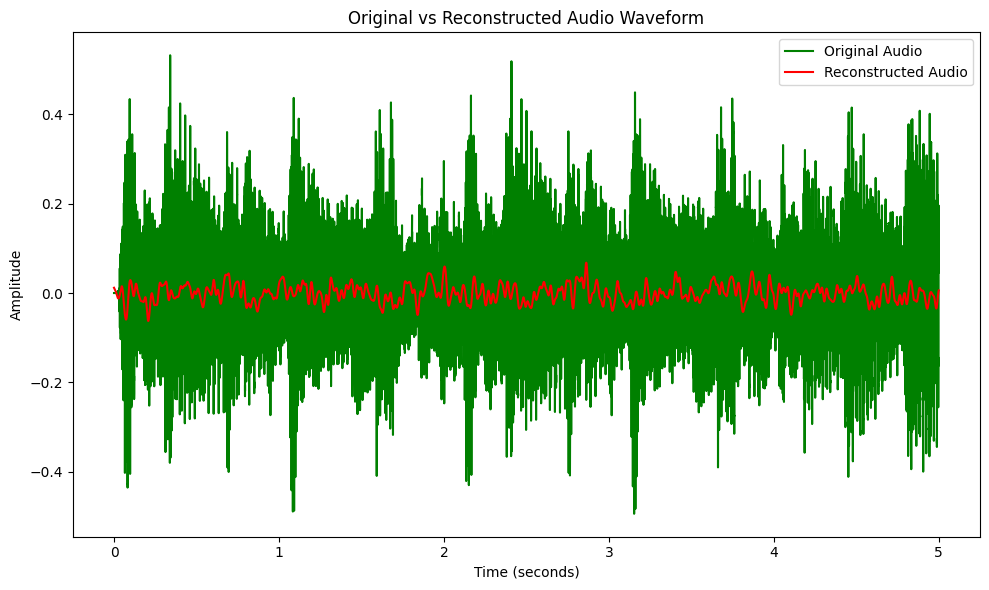

In [ ]:
import matplotlib.pyplot as plt

# Convert PyTorch tensors to NumPy arrays
original_audio_np = audio.numpy()
reconstructed_audio_np = reconstructed_audio

# Time axis
time_axis = np.linspace(0, original_audio_np.shape[0] / sr, num=len(original_audio_np))

plt.figure(figsize=(10, 6))

# Plot both original and reconstructed audio
plt.plot(time_axis, original_audio_np, label='Original Audio', color='g')
plt.plot(time_axis, reconstructed_audio_np, label='Reconstructed Audio', color='red')

plt.title('Original vs Reconstructed Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import Audio
Audio(reconstructed_audio_np, rate = sr)